In [1]:
import pandas as pd
import os
import glob

import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator

import geopandas as gpd

/tmp/ipykernel_1620233/2937115337.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
water = gpd.read_file('/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/coastal_data/water.gpkg')

In [3]:
def dms2decimal(s):
    sp = s.split('-')
    decimal = float(sp[0]) + float(sp[1])/60 +float(sp[2][:-1])/60/60
    sign = 1 if sp[2][-1] == 'N' or sp[2][-1]=='E' else -1
    return decimal*sign

In [4]:
def read_Nonna_bathy(fname):
    df = pd.read_table(fname)
    df['Longitude'] = df['Long (DMS)'].apply(dms2decimal)
    df['Latitude'] = df['Lat (DMS)'].apply(dms2decimal)
    return df

In [5]:
data_dir = '/home/soontiensn/data/gpsc-work7/uncertainty/stlawrence-poc/Nonna_Bathymetry-STLE/Bathymetry/'
files = glob.glob(os.path.join(data_dir, '*.txt'))
dfs = []
for f in files:
    df = read_Nonna_bathy(f)
    dfs.append(df)
d = pd.concat(dfs, ignore_index=True)

In [6]:
dx = d.to_xarray()
dx_pos = dx.where(dx['Depth (m)']>=0,drop=True)

In [7]:
lon_min=-69
lon_max=-67
lat_min=48.25
lat_max=49.5

Text(0.5, 1.0, 'NONNA depths')

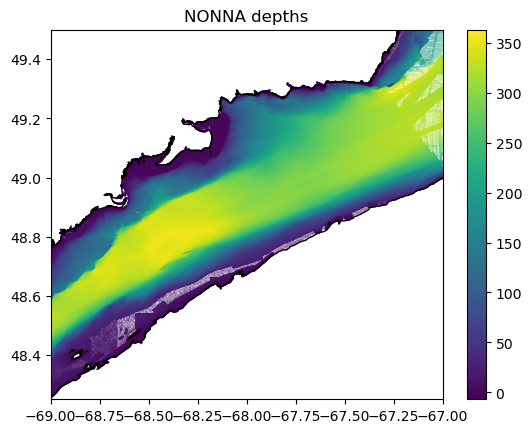

In [8]:
fig, ax = plt.subplots(1,1)
mesh = ax.scatter(dx['Longitude'].values, dx['Latitude'].values, 
                  c=dx['Depth (m)'].values,marker='.',s=0.1)
plt.colorbar(mesh, ax=ax)
water.boundary.plot(color='k', lw=1,ax=ax)
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.set_title('NONNA depths')

Text(0.5, 1.0, 'Only positve NONNA depths')

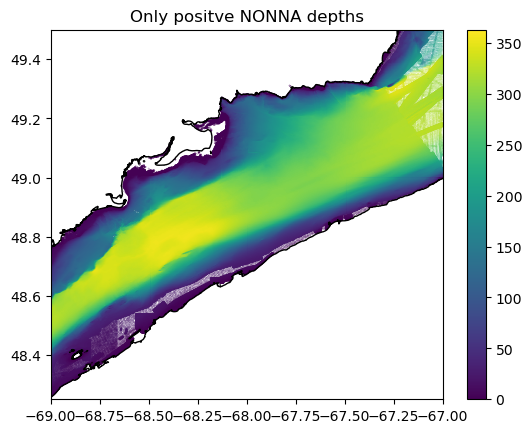

In [9]:
fig, ax = plt.subplots(1,1)
mesh = ax.scatter(dx_pos['Longitude'].values, dx_pos['Latitude'].values, 
                  c=dx_pos['Depth (m)'].values,marker='.', s=0.1)
plt.colorbar(mesh, ax=ax)
water.boundary.plot(color='k', lw=1,ax=ax)
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.set_title('Only positve NONNA depths')

In [10]:
# Start the regriddding
lon_min=-69
lon_max=-67
lat_min=48.25
lat_max=49.5

# set up grid
step=0.001
lons = np.arange(lon_min, lon_max+step, step)
lats = np.arange(lat_min, lat_max+step, step)
lonss, latss = np.meshgrid(lons, lats)

In [11]:

depths = griddata((dx.Longitude, dx.Latitude), dx['Depth (m)'], (lonss, latss))

(48.25, 49.5)

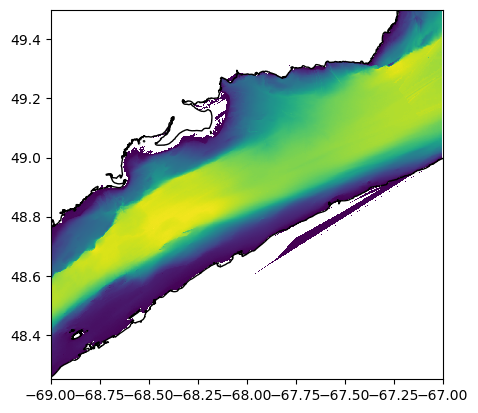

In [12]:
fig, ax = plt.subplots(1,1)
dmask = np.ma.masked_less_equal(depths, 0)
ax.pcolormesh(lonss, latss, dmask)
water.boundary.plot(color='k', lw=1,ax=ax)
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])

In [13]:
hit = np.histogram2d(dx['Longitude'], dx['Latitude'], bins = (lons, lats), weights=dx['Depth (m)'])

In [14]:
hitcount = np.histogram2d(dx['Longitude'], dx['Latitude'], bins = (lons, lats))
print(hitcount[0].argmax())

1257


/tmp/ipykernel_1620233/1905495222.py:4: RuntimeWarning: invalid value encountered in divide
  b=hit[0]/hitcount[0]


Text(0.5, 1.0, 'plotting the Gridded histogram - only depths>0')

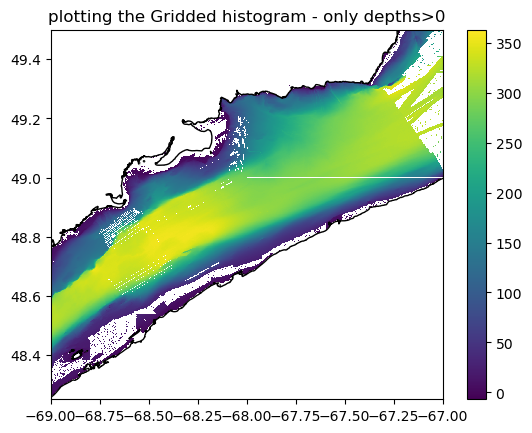

In [15]:
fig,ax=plt.subplots(1,1)
x = (hit[1][:-1] + hit[1][1:]) / 2
y = (hit[2][:-1] + hit[2][1:]) / 2
b=hit[0]/hitcount[0]
b = np.ma.masked_invalid(b)
b = np.ma.masked_less_equal(b,0)
mesh=ax.pcolormesh(x,y, b.T,vmin=dx['Depth (m)'].min(),vmax=dx['Depth (m)'].max())
plt.colorbar(mesh,ax=ax)
water.boundary.plot(color='k', lw=1,ax=ax)
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.set_title('plotting the Gridded histogram - only depths>0')

In [16]:
inds = np.where(~b.T.flatten().mask)

In [17]:

xn = xx.flatten()[inds]
yn = yy.flatten()[inds]
bn = b.T.flatten()[inds]

NameError: name 'xx' is not defined

In [ ]:
depths = griddata((xn,yn), bn, (lonss, latss),)

In [ ]:
fig, ax = plt.subplots(1,1)
dmask = np.ma.masked_less_equal(depths, 0)
ax.pcolormesh(lonss, latss,dmask,vmin=dx['Depth (m)'].min(),vmax=dx['Depth (m)'].max())
water.boundary.plot(color='k', lw=1,ax=ax)
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.set_title('Plotting the interpolated baythy from histogram - only depths>0')


In [ ]:
fig, ax = plt.subplots(1,1)
bn=np.ma.masked_less_equal(bn,0)
mesh = ax.scatter(xn,yn, 
                  c=bn,marker='.', s=0.1)
plt.colorbar(mesh, ax=ax)
water.boundary.plot(color='k', lw=1,ax=ax)
ax.set_xlim([lon_min, lon_max])
ax.set_ylim([lat_min, lat_max])
ax.set_title('plotting the Scatter histogram - depths>0')

# Summary 

I'm not quite satisified with my attempts to grid this bathymetry to I'm switching to GEBCO